In [1]:
!pwd

/reg/data/ana03/scratch/cwang31/spi


In [2]:
# Load paths for using psana
%env SIT_ROOT=/reg/g/psdm/
%env SIT_DATA=/cds/group/psdm/data/
%env SIT_PSDM_DATA=/cds/data/psdm/

env: SIT_ROOT=/reg/g/psdm/
env: SIT_DATA=/cds/group/psdm/data/
env: SIT_PSDM_DATA=/cds/data/psdm/


In [16]:
import os
import logging
import torch
import socket
import pickle
import tqdm

from deepprojection.datasets.lite    import SPIDataset         , SPIOnlineDataset
from deepprojection.model import Shi2019Model
from deepprojection.encoders.convnet import Shi2019
from deepprojection.trainer          import SimpleTrainer      , ConfigTrainer
from deepprojection.validator        import SimpleValidator, ConfigValidator
from deepprojection.utils import MetaLog, init_logger, split_dataset, set_seed, NNSize, TorchModelAttributeParser, Config, EpochManager
from datetime import datetime
## from image_preprocess_faulty import DatasetPreprocess
from image_preprocess_half import DatasetPreprocess
# from image_preprocess_one_four import DatasetPreprocess

# [[[ SEED ]]]
seed = 0
set_seed(seed)

# [[[ CONFIG ]]]
timestamp = "2022_1204_2106_44"
frac_train = 0.5
frac_validate = 0.5

lr = 1e-3


size_sample_test = 1000
size_sample_per_class = None
size_batch = 100
online_shuffle = True
trans = None


# Configure the location to run the job...## 
drc_cwd = os.getcwd()

init_logger(log_name = 'validate.query.test', timestamp = timestamp, returns_timestamp = False)


# Clarify the purpose of this experiment...
hostname = socket.gethostname()
comments = f"""
            Hostname: {hostname}.

            Online training.

            Sample size (test)     : {size_sample_test}
            Sample size (per class) : {size_sample_per_class}
            Batch  size             : {size_batch}
            Online shuffle          : {online_shuffle}
            lr                      : {lr}

            """


# [[[ DATASET ]]]
# Set up parameters for an experiment...
drc_dataset   = 'fastdata'
fl_dataset    = '0000.binary.fastdata'    # Raw, just give it a try
path_dataset  = os.path.join(drc_dataset, fl_dataset)

# Load raw data...
with open(path_dataset, 'rb') as fh:
    dataset_list = pickle.load(fh)

In [ ]:
dataset_filter_list = tuple( data for data in dataset_list if data[1] != 0 )

In [ ]:
dataset_list = dataset_filter_list

In [17]:
# Split data...
data_train   , data_val_and_test = split_dataset(dataset_list     , frac_train   , seed = None)
data_validate, data_test         = split_dataset(data_val_and_test, frac_validate, seed = None)

# Define the test set
dataset_test = SPIOnlineDataset( dataset_list = data_test, 
                                 size_sample  = size_sample_test,
                                 size_sample_per_class = size_sample_per_class, 
                                 trans = trans, 
                                 seed  = None, )

In [18]:
# Preprocess dataset...
# Data preprocessing can be lengthy and defined in dataset_preprocess.py
img_orig            = dataset_test[0][0][0]   # idx, fetch img
dataset_preproc     = DatasetPreprocess(img_orig)
trans               = dataset_preproc.config_trans()
dataset_test.trans  = trans
img_trans           = dataset_test[0][0][0]

In [19]:
device = torch.cuda.current_device() if torch.cuda.is_available() else 'cpu'

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

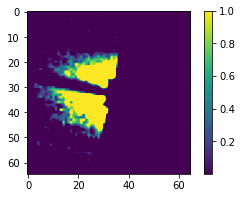

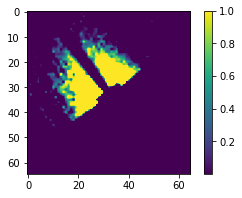

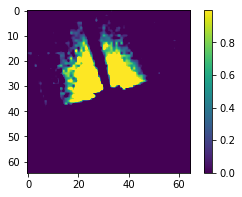

In [21]:
for _ in range(3):
    plt.figure(figsize = (5, 3))
    #data = img_orig
    data = dataset_test[0][0][0]
    vmin = data.mean()
    vmax = vmin + 1 * data.std()
    plt.imshow(data, vmin = vmin, vmax = vmax)
    plt.colorbar()

In [22]:
# [[[ IMAGE ENCODER ]]]
# Config the encoder...
size_y, size_x = img_trans.shape[-2:]
config_encoder = Config( name   = "Shi2019",
                         size_y = size_y,
                         size_x = size_x,
                         isbias = True )
encoder = Shi2019(config_encoder)


# [[[ MODEL ]]]
# Config the model...
config_model = Config( name = "Model", encoder = encoder, )
model = Shi2019Model(config_model)
model.init_params(from_timestamp = timestamp)

In [23]:
model.to(device)

Shi2019Model(
  (encoder): Shi2019(
    (feature_extractor): Sequential(
      (0): Conv2d(1, 5, kernel_size=(5, 5), stride=(1, 1))
      (1): BatchNorm2d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): PReLU(num_parameters=1)
      (3): Dropout(p=0.2, inplace=False)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(5, 3, kernel_size=(3, 3), stride=(1, 1))
      (6): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): PReLU(num_parameters=1)
      (8): Dropout(p=0.2, inplace=False)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(3, 2, kernel_size=(3, 3), stride=(1, 1))
      (11): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): PReLU(num_parameters=1)
      (13): Dropout(p=0.2, inplace=False)
      (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_m

In [24]:
# Validate an epoch...
# Load model state...
model.eval()
loader_test = torch.utils.data.DataLoader( dataset_test, shuffle     = True, 
                                   pin_memory  = True, 
                                   batch_size  = size_batch,
                                   num_workers = 1 )

In [25]:
# New container to store validation result (thus res_dict) for each label...
labels = set([i[1] for i in dataset_test])
res_dict = {}
for label in labels: res_dict[label] = { i : [] for i in labels }

In [26]:
# Train each batch...
prob_threshold = 0.5
batch = tqdm.tqdm(enumerate(loader_test), total = len(loader_test), disable = False)
for step_id, entry in batch:
    batch_imgs, batch_labels, batch_metadata = entry
    batch_imgs = batch_imgs.to(device, dtype = torch.float)
    batch_labels = batch_labels[:, None].to(device, dtype = torch.float)

    with torch.no_grad():
        batch_logit, loss = model.forward(batch_imgs, batch_labels)
            
    batch_label_pred = torch.where(torch.sigmoid(batch_logit) > prob_threshold, torch.ones_like(batch_logit), torch.zeros_like(batch_logit))
    
    for i in range(len(batch_label_pred)):
        label_pred = batch_label_pred[i].item()
        label_true = batch_labels[i].item()
        res_dict[label_pred][label_true].append( batch_metadata[i] )

100%|██████████| 10/10 [00:02<00:00,  3.92it/s]


In [27]:
class MacroMetric:
    def __init__(self, res_dict):
        self.res_dict = res_dict


    def reduce_confusion(self, label):
        ''' Given a label, reduce multiclass confusion matrix to binary
            confusion matrix.
        '''
        res_dict    = self.res_dict
        labels      = res_dict.keys()
        labels_rest = [ i for i in labels if not i == label ]

        # Early return if non-exist label is passed in...
        if not label in labels: 
            print(f"label {label} doesn't exist!!!")
            return None

        # Obtain true positive...
        tp = len(res_dict[label][label])
        fp = sum( [ len(res_dict[label][i]) for i in labels_rest ] )
        tn = sum( sum( len(res_dict[i][j]) for j in labels_rest ) for i in labels_rest )
        fn = sum( [ len(res_dict[i][label]) for i in labels_rest ] )

        return tp, fp, tn, fn


    def get_metrics(self, label):
        # Early return if non-exist label is passed in...
        confusion = self.reduce_confusion(label)
        if confusion is None: return None

        # Calculate metrics...
        tp, fp, tn, fn = confusion
        accuracy    = (tp + tn) / (tp + tn + fp + fn)
        precision   = tp / (tp + fp)
        recall      = tp / (tp + fn)
        specificity = tn / (tn + fp) if tn + fp > 0 else None
        f1_inv      = (1 / precision + 1 / recall)
        f1          = 2 / f1_inv

        return accuracy, precision, recall, specificity, f1


In [28]:
# Get macro metrics...
macro_metric = MacroMetric(res_dict)

# Formating purpose...
disp_dict = { 0 : "not-single",
              1 : "single-hit",
            }

# Report multiway classification...
msgs = []
for label_pred in sorted(labels):
    disp_text = disp_dict[label_pred]
    msg = f"{disp_text}  |"
    for label_real in sorted(labels):
        num = len(res_dict[label_pred][label_real])
        msg += f"{num:>12d}"

    metrics = macro_metric.get_metrics(label_pred)
    for metric in metrics:
        msg += f"{metric:>12.2f}"
    msgs.append(msg)

msg_header = " " * (msgs[0].find("|") + 1)
for label in sorted(labels): 
    disp_text = disp_dict[label]
    msg_header += f"{disp_text:>12s}"

for header in [ "accuracy", "precision", "recall", "specificity", "f1" ]:
    msg_header += f"{header:>12s}"
print(msg_header)

msg_headerbar = "-" * len(msgs[0])
print(msg_headerbar)
for msg in msgs:
    print(msg)

               not-single  single-hit    accuracy   precision      recall specificity          f1
-------------------------------------------------------------------------------------------------
not-single  |         452           3        0.93        0.99        0.87        0.99        0.93
single-hit  |          65         480        0.93        0.88        0.99        0.87        0.93


#### Distribution of embedding distances

In [ ]:
import numpy as np

hy, hx = np.histogram(batch_dist_support_list, bins = 50, density = True)

plt.figure( figsize = (20, 8) )
plt.plot(hx[:-1], hy)
plt.legend(bbox_to_anchor=(1.25, 1.00));
plt.title(f'embedding distance distribution, bin width = {hx[1]-hx[0]:.4f}');

In [ ]:
np.sum(hy * (hx[1:] - hx[:-1]))    # Density means sum of bin_frequency_density * bin_width.

#### Confusion matrix

##### Focus on min embedding distance

In [ ]:
import numpy as np
idx_min_value_list = np.argmin(batch_dist_support_list, axis = 1)
idx_min_value_list.shape

In [ ]:
min_value_list = np.min(batch_dist_support_list, axis = 1)
min_value_list.shape

In [ ]:
import numpy as np

hy, hx = np.histogram(min_value_list, bins = 50, density = True)

plt.figure( figsize = (20, 8) )
plt.plot(hx[:-1], hy)
plt.legend(bbox_to_anchor=(1.25, 1.00));
plt.title(f'min embedding distance distribution, bin width = {hx[1]-hx[0]:.4f}');

In [ ]:
# Sample from the min embedding distance distribution
value_to_sample = 1.5
window_size = 0.25
selection_mask = np.logical_and(value_to_sample - window_size < min_value_list, min_value_list < value_to_sample + window_size)
selection_tuple = np.argwhere(selection_mask)    # (idx_batch, idx_example)
print(f"Total events = {len(selection_tuple)}")
num_example_in_batch = len(batch_metadata_query_list[0][0])
for idx_batch, idx_example in selection_tuple[:10]:
    fig = plt.figure(figsize=(18,6))

    nrows = 1
    ncols = 4
    gspec = fig.add_gridspec( nrows, ncols,
                              width_ratios  = [1, 1, 1, 1],
                              #height_ratios = [1, 1/25],
                            )
    ax_list  = [ fig.add_subplot(gspec[0, i]) for i in range(ncols) ]
    #ax_list += [ fig.add_subplot(gspec[1, i]) for i in range(ncols) ]

    idx_query = idx_batch * num_example_in_batch + idx_example
    img_query = dataset_test[idx_query][0]
    
    #img_support_chosen = dataset_test[idx_query][idx_support_chosen]
    img_support_list = dataset_test[idx_query][1:1+3]
    
    data = img_query[0]
    vmin = data.mean()
    vmax = vmin + 1 * data.std()
    im = ax_list[0].imshow(data, vmin = vmin, vmax = vmax)
    #plt.colorbar(im, cax = ax_list[2], orientation="horizontal", pad = 0.05)
    metadata_query = batch_metadata_query_list[idx_batch][0][idx_example]
    ax_list[0].set_title(metadata_query)

    for idx_support, img_support in enumerate(img_support_list):
        data = img_support[0]
        vmin = data.mean()
        vmax = vmin + 1 * data.std()
        im = ax_list[idx_support+1].imshow(data, vmin = vmin, vmax = vmax)   
        #plt.colorbar(im, cax = ax_list[3], orientation="horizontal", pad = 0.05)
        metadata_support = batch_metadata_support_list[idx_batch][idx_support][idx_example]
        dist_support = batch_dist_support_list[idx_batch][idx_support][idx_example]
        ax_list[idx_support+1].set_title(f"{metadata_support}, d = {dist_support:.2f}")

##### Back to confusion matrix

In [ ]:
batch_metadata_support_selected_list = []
for idx_batch in range(len(batch_metadata_support_list)):
    metadata_support_selected_list = []
    for idx_example in range(len(batch_metadata_support_list[0][0])):
        idx_min_value = idx_min_value_list[idx_batch][idx_example]
        metadata_support_selected = batch_metadata_support_list[idx_batch][idx_min_value][idx_example]
        metadata_support_selected_list.append(metadata_support_selected)
    batch_metadata_support_selected_list.append(metadata_support_selected_list)

In [ ]:
class MacroMetric:
    def __init__(self, res_dict):
        self.res_dict = res_dict


    def reduce_confusion(self, label):
        ''' Given a label, reduce multiclass confusion matrix to binary
            confusion matrix.
        '''
        res_dict    = self.res_dict
        labels      = res_dict.keys()
        labels_rest = [ i for i in labels if not i == label ]

        # Early return if non-exist label is passed in...
        if not label in labels: 
            print(f"label {label} doesn't exist!!!")
            return None

        # Obtain true positive...
        tp = len(res_dict[label][label])
        fp = sum( [ len(res_dict[label][i]) for i in labels_rest ] )
        tn = sum( sum( len(res_dict[i][j]) for j in labels_rest ) for i in labels_rest )
        fn = sum( [ len(res_dict[i][label]) for i in labels_rest ] )

        return tp, fp, tn, fn


    def get_metrics(self, label):
        # Early return if non-exist label is passed in...
        confusion = self.reduce_confusion(label)
        if confusion is None: return None

        # Calculate metrics...
        tp, fp, tn, fn = confusion
        accuracy    = (tp + tn) / (tp + tn + fp + fn)
        precision   = tp / (tp + fp)
        recall      = tp / (tp + fn)
        specificity = tn / (tn + fp) if tn + fp > 0 else None
        f1_inv      = (1 / precision + 1 / recall)
        f1          = 2 / f1_inv

        return accuracy, precision, recall, specificity, f1


In [ ]:
labels = set([ metadata.split()[-1] for batch_metadata in batch_metadata_query_list for metadata in batch_metadata[0] ])
labels

In [ ]:
# New container to store validation result (thus res_dict) for each label...
res_dict = {}
for label in labels: res_dict[label] = { i : [] for i in labels }

In [ ]:
for idx_batch in range(len(batch_metadata_support_list)):
    for idx_example in range(len(batch_metadata_query_list[idx_batch][0])):
        metadata_true = batch_metadata_query_list[idx_batch][0][idx_example]
        metadata_pred = batch_metadata_support_selected_list[idx_batch][idx_example]
        label_true = metadata_true.split()[-1]
        label_pred = metadata_pred.split()[-1]
        res_dict[label_pred][label_true].append( (metadata_true, metadata_pred) )

In [ ]:
# Get macro metrics...
macro_metric = MacroMetric(res_dict)

# Formating purpose...
disp_dict = { 0 : "not-single",
              1 : "single-hit",
            }

# Report multiway classification...
msgs = []
for label_pred in sorted(labels):
    disp_text = disp_dict[label_pred]
    msg = f"{disp_text}  |"
    for label_real in sorted(labels):
        num = len(res_dict[label_pred][label_real])
        msg += f"{num:>12d}"

    metrics = macro_metric.get_metrics(label_pred)
    for metric in metrics:
        msg += f"{metric:>12.2f}"
    msgs.append(msg)

msg_header = " " * (msgs[0].find("|") + 1)
for label in sorted(labels): 
    disp_text = disp_dict[label]
    msg_header += f"{disp_text:>12s}"

for header in [ "accuracy", "precision", "recall", "specificity", "f1" ]:
    msg_header += f"{header:>12s}"
print(msg_header)

msg_headerbar = "-" * len(msgs[0])
print(msg_headerbar)
for msg in msgs:
    print(msg)

In [ ]:
timestamp

#### Source/Sample the wrong prediction

pred, true

In [ ]:
res_dict['1']['2']

In [ ]:
# New container to store validation result (thus res_dict) for each label...
idx_res_dict = {}
for label in labels: idx_res_dict[label] = { i : [] for i in labels }

In [ ]:
for idx_batch in range(len(batch_metadata_support_list)):
    for idx_example in range(len(batch_metadata_query_list[idx_batch][0])):
        metadata_true = batch_metadata_query_list[idx_batch][0][idx_example]
        metadata_pred = batch_metadata_support_selected_list[idx_batch][idx_example]
        label_true = metadata_true.split()[-1]
        label_pred = metadata_pred.split()[-1]
        idx_min_value = idx_min_value_list[idx_batch][idx_example]
        idx_res_dict[label_pred][label_true].append( (idx_batch, idx_example, idx_min_value) )

In [ ]:
idx_res_dict['1']['2']

In [ ]:
failed_test_list = idx_res_dict['1']['2']
num_example_in_batch = len(batch_metadata_query_list[0][0])
for idx_batch, idx_example, idx_support_chosen in failed_test_list[:]:
    fig = plt.figure(figsize=(18,6))

    nrows = 1
    ncols = 4
    gspec = fig.add_gridspec( nrows, ncols,
                              width_ratios  = [1, 1, 1, 1],
                              #height_ratios = [1, 1/25],
                            )
    ax_list  = [ fig.add_subplot(gspec[0, i]) for i in range(ncols) ]
    #ax_list += [ fig.add_subplot(gspec[1, i]) for i in range(ncols) ]

    idx_query = idx_batch * num_example_in_batch + idx_example
    img_query = dataset_test[idx_query][0]
    
    #img_support_chosen = dataset_test[idx_query][idx_support_chosen]
    img_support_list = dataset_test[idx_query][1:1+3]
    
    data = img_query[0]
    vmin = data.mean()
    vmax = vmin + 1 * data.std()
    im = ax_list[0].imshow(data, vmin = vmin, vmax = vmax)
    #plt.colorbar(im, cax = ax_list[2], orientation="horizontal", pad = 0.05)
    metadata_query = batch_metadata_query_list[idx_batch][0][idx_example]
    ax_list[0].set_title(metadata_query)

    for idx_support, img_support in enumerate(img_support_list):
        data = img_support[0]
        vmin = data.mean()
        vmax = vmin + 1 * data.std()
        im = ax_list[idx_support+1].imshow(data, vmin = vmin, vmax = vmax)   
        #plt.colorbar(im, cax = ax_list[3], orientation="horizontal", pad = 0.05)
        metadata_support = batch_metadata_support_list[idx_batch][idx_support][idx_example]
        dist_support = batch_dist_support_list[idx_batch][idx_support][idx_example]
        ax_list[idx_support+1].set_title(f"{metadata_support}, d = {dist_support:.2f}")

#### Source/Sample the right prediction

pred, true

In [ ]:
res_dict['1']['1']

In [ ]:
# New container to store validation result (thus res_dict) for each label...
idx_res_dict = {}
for label in labels: idx_res_dict[label] = { i : [] for i in labels }

In [ ]:
for idx_batch in range(len(batch_metadata_support_list)):
    for idx_example in range(len(batch_metadata_query_list[idx_batch][0])):
        metadata_true = batch_metadata_query_list[idx_batch][0][idx_example]
        metadata_pred = batch_metadata_support_selected_list[idx_batch][idx_example]
        label_true = metadata_true.split()[-1]
        label_pred = metadata_pred.split()[-1]
        idx_min_value = idx_min_value_list[idx_batch][idx_example]
        idx_res_dict[label_pred][label_true].append( (idx_batch, idx_example, idx_min_value) )

In [ ]:
idx_res_dict['1']['2']

In [ ]:
test_list = idx_res_dict['1']['1']
num_example_in_batch = len(batch_metadata_query_list[0][0])
for idx_batch, idx_example, idx_support_chosen in test_list[:10]:
    fig = plt.figure(figsize=(18,6))

    nrows = 1
    ncols = 4
    gspec = fig.add_gridspec( nrows, ncols,
                              width_ratios  = [1, 1, 1, 1],
                              #height_ratios = [1, 1/25],
                            )
    ax_list  = [ fig.add_subplot(gspec[0, i]) for i in range(ncols) ]
    #ax_list += [ fig.add_subplot(gspec[1, i]) for i in range(ncols) ]

    idx_query = idx_batch * num_example_in_batch + idx_example
    img_query = dataset_test[idx_query][0]
    
    #img_support_chosen = dataset_test[idx_query][idx_support_chosen]
    img_support_list = dataset_test[idx_query][1:1+3]
    
    data = img_query[0]
    vmin = data.mean()
    vmax = vmin + 1 * data.std()
    im = ax_list[0].imshow(data, vmin = vmin, vmax = vmax)
    #plt.colorbar(im, cax = ax_list[2], orientation="horizontal", pad = 0.05)
    metadata_query = batch_metadata_query_list[idx_batch][0][idx_example]
    ax_list[0].set_title(metadata_query)

    for idx_support, img_support in enumerate(img_support_list):
        data = img_support[0]
        vmin = data.mean()
        vmax = vmin + 1 * data.std()
        im = ax_list[idx_support+1].imshow(data, vmin = vmin, vmax = vmax)   
        #plt.colorbar(im, cax = ax_list[3], orientation="horizontal", pad = 0.05)
        metadata_support = batch_metadata_support_list[idx_batch][idx_support][idx_example]
        dist_support = batch_dist_support_list[idx_batch][idx_support][idx_example]
        ax_list[idx_support+1].set_title(f"{metadata_support}, d = {dist_support:.2f}")

#### Check unique items in a dataset

In [ ]:
dataset_train_unique = set(data[2] for data in dataset_train)

In [ ]:
dataset_train_unique

In [ ]:
[ len([ data for data in dataset_train_unique if data[-1] == str(i) ]) for i in range(3) ]

In [ ]:
[ len(dataset_train.label_seqi_dict[i]) for i in range(3) ]